# 1. Data preparation

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
%load_ext autoreload
%autoreload 2
from final_project.smlm_3d.config.datasets import dataset_configs

from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import TrainingDataSet, ExperimentalDataSet, GenericDataSet, MultiTrainingDataset
from final_project.smlm_3d.workflow_v2 import concat_dataset_features

BOUND = 16
GenericDataSet.bound = BOUND

z_range = 1000

dataset = '20220425_Miguel'
version = ''
cfg = dataset_configs[dataset]['training_20nm']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
train_dataset = TrainingDataSet(cfg, fit_plane_z=True, transform_data=False, z_range=1000, split_data=True, add_noise=True, filter_emitters_proximity=False)
print(train_dataset.data['train'][0][0].shape)


# dataset = '20220506_Miguel_beads'
# cfgs = [
#     dataset_configs[dataset]['training_2'],
#     dataset_configs[dataset]['training_4'],
#     dataset_configs[dataset]['training_5']
# ]

# cfg = cfgs[0]
# ds = MultiTrainingDataset(cfgs, fit_plane_z=True, 
#                           filter_emitters_proximity=True, 
#                           transform_data=False, 
#                           z_range=2000, 
#                           add_noise=4, 
#                           split_data=True, 
#                           normalize_psf=True)

# train_dataset = ds.merge()

# train_dataset.prepare_debug()

Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/20220425_Miguel/2um_20nm_20nm_beads_1/2um_20nm_20nm_beads_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20220425_Miguel/2um_20nm_20nm_beads_1/2um_20nm_20nm_beads_1_MMStack_Default.csv
using image sharpness
10 emitters before filtering
10 emitters after borders
Failed to fit image gradient.
Adding noise
N repeats 10
(7469, 32, 32)
(7469, 32, 32, 1)


Functions above do the following operations
1. Starting from a set of X/Y images of a sample, taken at different focal depths

/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


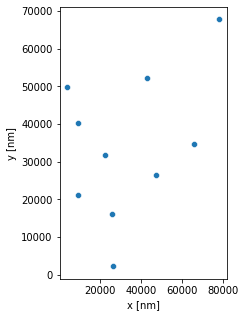

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(train_dataset.csv_data['x [nm]'], train_dataset.csv_data['y [nm]'])
plt.show()

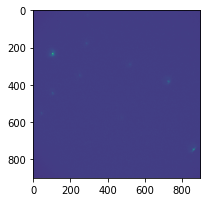

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(train_dataset.img[100])

2. For each dot of light, cut out a stack of images around the dot (below example shows focus/defocus in steps of 200nm along Z axis)

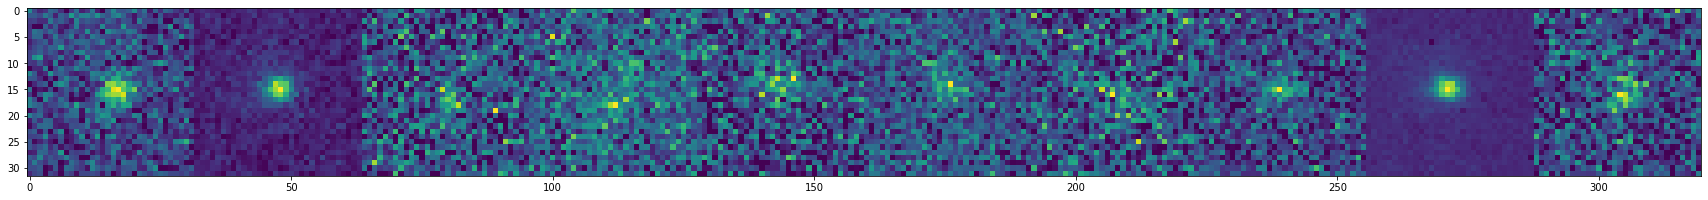

In [5]:
example_idx = 5
example_stack = np.hstack(train_dataset.data['train'][0][0][slice(example_idx*199, (example_idx+1)*199, 20)]).squeeze()
plt.rcParams['figure.figsize'] = [30, 50]
plt.imshow(example_stack)


3. Estimate 'ground truth' 0 position (focus point) of each bead using peak brightness. This is inaccurate due to high SNR ratio in image, so refine these positions by assuming dots of light sit on a plane, model new Z positions as least squares of plane and exclude poorly located points
4. Normalise each image to range [0,1]

In [6]:
example_idx = 5
example_stack = train_dataset.data['train'][0][0][slice(example_idx*199, (example_idx+1)*199, 20)].squeeze()
# Checking min/max values from for a set of images
print(example_stack.min(axis=(1,2)))
print(example_stack.max(axis=(1,2)))
      

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Rows 3 Cols 10 n_spaces 30 n_psfs 21


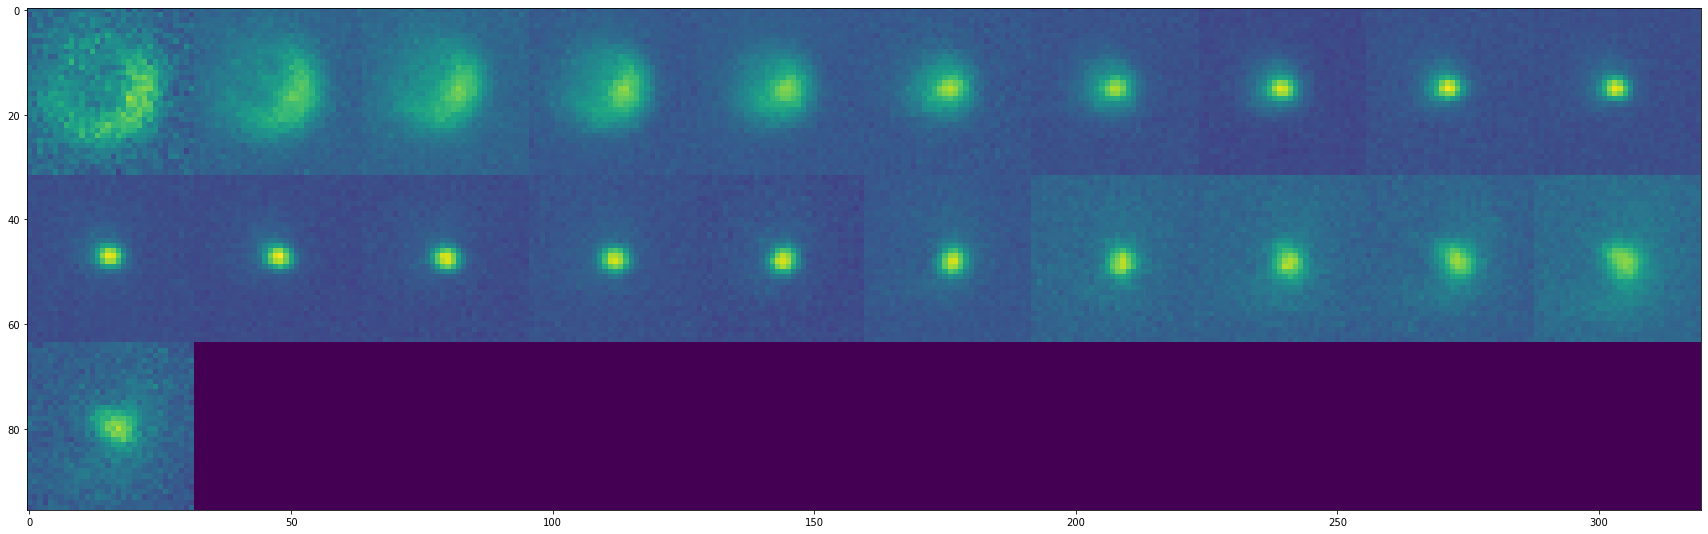

In [7]:
# Create PSF in n steps
from final_project.smlm_3d.data.visualise import grid_psfs

psf = []
for i in range(-1000, 1001, 100):
    min_z = i-25
    max_z = i+25
    idx = np.argwhere((train_dataset.data['train'][1] < max_z) & (train_dataset.data['train'][1] > min_z)).squeeze()
    imgs = train_dataset.data['train'][0][0].squeeze()[idx]
    mean_img = np.mean(imgs, axis=0)
    psf.append(mean_img)
plt.imshow(grid_psfs(psf))
plt.show()
    


(7469, 32, 32, 1)
Rows 10 Cols 10 n_spaces 100 n_psfs 100


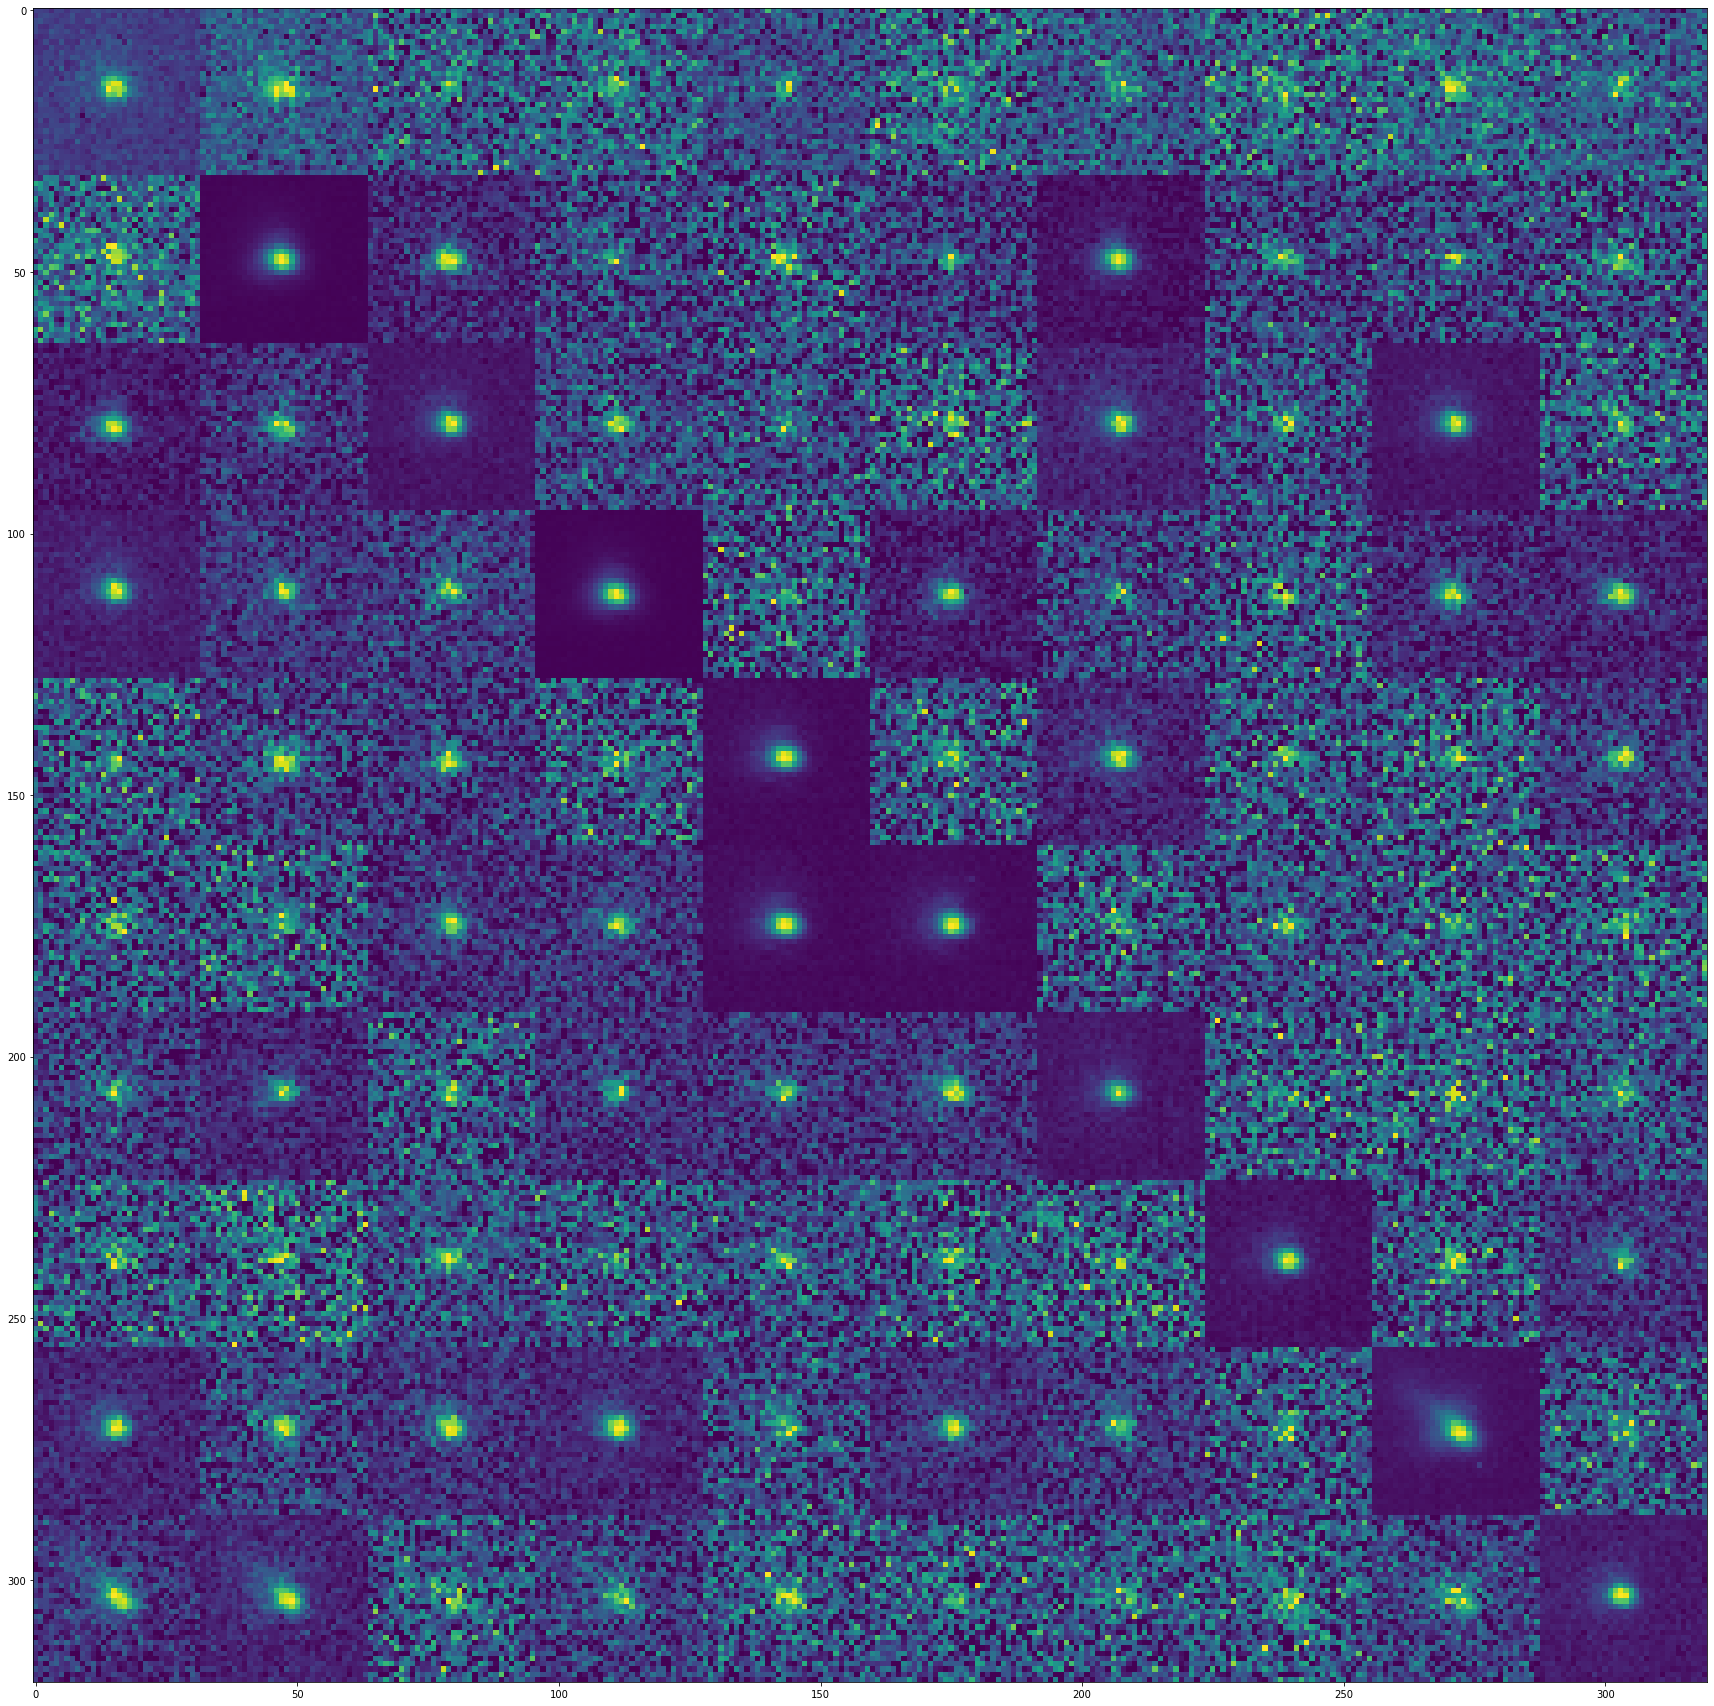

In [8]:
# checking zero-alignment of beads
from final_project.smlm_3d.data.visualise import grid_psfs
near_zero_idx = np.argwhere(abs(train_dataset.data['train'][1]) < cfg['voxel_sizes'][0]).squeeze()
near_zero_imgs = train_dataset.data['train'][0][0].squeeze()[near_zero_idx]

near_zero_imgs = near_zero_imgs[0:100]
print(train_dataset.data['train'][0][0].shape)

plt.rcParams['figure.figsize'] = [30, 50]
plt.imshow(grid_psfs(near_zero_imgs))


# 2. Training the model

Currently, I'm using 2 'calibration' datasets to see if my model can adapt from one to the other.
All of the training dataset is used for training, and the 2nd dataset is used as validation.

In [9]:
import os

if version is not None:
    model_name = f'{dataset}'
model_path = os.path.join('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt', f'{dataset}{version}')
def save_model(model):
    model.save_weights(model_path)
#     model.save(model_path, save_format='h5')
    print(model_path)
    print('Saved model!')

def load_model(model):
    print('Loading model...')
    print(model_path)
    model.load_weights(model_path)
    return model
#     return keras.models.load_model(model_path)


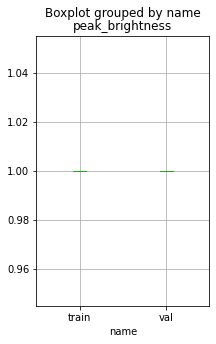

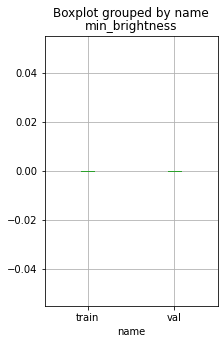

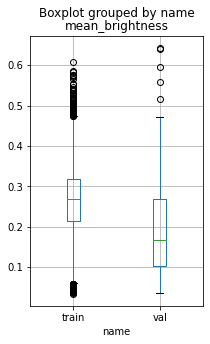

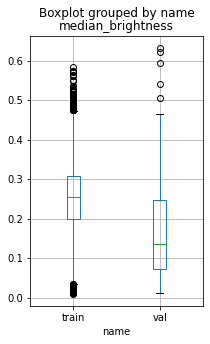

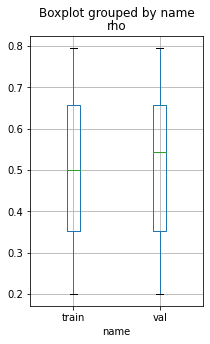

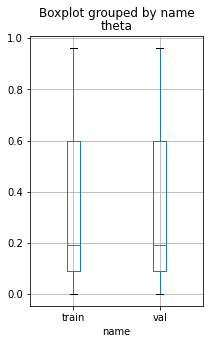

In [10]:
import pandas as pd
plt.rcParams['figure.figsize'] = [3, 5]
def gather_stats(dataset, name, dataset_type='training'):
    records = [] 
    
    if dataset_type == 'training':
        (imgs, coords), _ = dataset
    else:
        imgs, coords = dataset
    
    for img, coord in zip(imgs, coords):
        results = {
            'name': name,
            'peak_brightness': img.max(),
            'min_brightness': img.min(),
            'mean_brightness': img.mean(),
            'median_brightness': np.median(img),
            'rho': coord[0],
            'theta': coord[1],
        }
        records.append(results)
        
    return pd.DataFrame.from_records(records)

if 'all' not in train_dataset.data:
    train = train_dataset.data['train']
    val = train_dataset.data['val']
    
    records = []
    records.append(gather_stats(train, 'train'))
    records.append(gather_stats(val, 'val'))
    
    df = pd.concat(records)
    for col in list(df):
        if col != 'name':
            df.boxplot(by='name', column=col)
    
    

In [11]:
# from scipy.optimize import curve_fit

# def shift_correction(y, y_pred):
#     y_pred = y_pred -  tf.math.reduce_mean(y_pred) +  tf.math.reduce_mean(y)
#     return y_pred


In [12]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import RandomTranslation, GaussianNoise, Normalization, BatchNormalization, ReLU
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers as Layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D

from final_project.smlm_3d.workflow_v2 import eval_model

SEED = 42
class ResBlock(Model):
    def __init__(self, channels, stride=1, name='ResBlock'):
        super(ResBlock, self).__init__(name=name)
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.transpose = RandomTranslation(0.1, 0.1)
        self.feature_extraction = Sequential([
            Conv2D(64, 7, 2, padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(3, 2),
            ResBlock(64, name='ResBlock64_1'),
            ResBlock(64, name='ResBlock64_2'),
            ResBlock(64, name='ResBlock64_3'),
            ResBlock(128, 2, name='ResBlock128_1'),
            ResBlock(128, name='ResBlock128_2'),
            ResBlock(128, name='ResBlock128_3'),
            ResBlock(128, name='ResBlock128_4'),
            ResBlock(256, 2, name='ResBlock256_1'),
            ResBlock(256, name='ResBlock256_2'),
            ResBlock(256, name='ResBlock256_3'),
            ResBlock(256, name='ResBlock256_4'),
            ResBlock(256, name='ResBlock256_5'),
            ResBlock(256, name='ResBlock256_6'),
            ResBlock(512, 2, name='ResBlock512_1'),
            ResBlock(512, name='ResBlock512_2'),
            ResBlock(512, name='ResBlock512_3')
        ])
#         self.conv1 = Conv2D(64, 7, 2, padding='same')
#         self.bn = BatchNormalization()
#         self.relu = ReLU()
#         self.mp1 = MaxPooling2D(3, 2)

#         self.conv2_1 = ResBlock(64)
#         self.conv2_2 = ResBlock(64)
#         self.conv2_3 = ResBlock(64)

#         self.conv3_1 = ResBlock(128, 2)
#         self.conv3_2 = ResBlock(128)
#         self.conv3_3 = ResBlock(128)
#         self.conv3_4 = ResBlock(128)

#         self.conv4_1 = ResBlock(256, 2)
#         self.conv4_2 = ResBlock(256)
#         self.conv4_3 = ResBlock(256)
#         self.conv4_4 = ResBlock(256)
#         self.conv4_5 = ResBlock(256)
#         self.conv4_6 = ResBlock(256)

#         self.conv5_1 = ResBlock(512, 2)
#         self.conv5_2 = ResBlock(512)
#         self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(1024)
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(1024)
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(1)

    def call(self, inp, training):
        x, coords = inp
        
        x = self.transpose(x)
        x = self.feature_extraction(x)
#         x = self.conv1(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.mp1(x)

#         x = self.conv2_1(x)
#         x = self.conv2_2(x)
#         x = self.conv2_3(x)

#         x = self.conv3_1(x)
#         x = self.conv3_2(x)
#         x = self.conv3_3(x)
#         x = self.conv3_4(x)

#         x = self.conv4_1(x)
#         x = self.conv4_2(x)
#         x = self.conv4_3(x)
#         x = self.conv4_4(x)
#         x = self.conv4_5(x)
#         x = self.conv4_6(x)

#         x = self.conv5_1(x)
#         x = self.conv5_2(x)
#         x = self.conv5_3(x)

        x = self.pool(x)

        # Concat norm X/Y coordinates
        x = tf.concat((x, coords), axis=1)

        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        # Restrict to valid output range [-1000, 1000]    
#         x = tf.tanh(x) * 1000
        return x

#     def test_step(self, data):
#         (img, coords), y = data
#         y_pred = self((img, coords), training=False)

#         shifted_pred = shift_correction(y, y_pred)

#         self.compiled_loss(y, shifted_pred, regularization_losses=self.losses)
#         self.compiled_metrics.update_state(y, shifted_pred)
#         # Return a dict mapping metric names to current value.
#         # Note that it will include the loss (tracked in self.metrics).
#         return {m.name: m.result() for m in self.metrics}
        
            
            
def load_regression_model():

    # model = Sequential()
    # model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='linear'))

    model = ResNet34()
    
#     model = res34()
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=0.01, decay=1e-6),metrics=['mean_absolute_error'])
    return model


Epoch 1/5000
1/1 [==============================] - 7s 7s/step - loss: 306748.3438 - mean_absolute_error: 475.6751 - val_loss: 408357792.0000 - val_mean_absolute_error: 19238.4395 - lr: 0.0100
Epoch 2/5000
1/1 [==============================] - 0s 258ms/step - loss: 301362.7500 - mean_absolute_error: 464.4074 - val_loss: 614312029427844775936.0000 - val_mean_absolute_error: 23517831168.0000 - lr: 0.0100
Epoch 3/5000
1/1 [==============================] - 0s 253ms/step - loss: 3729971.0000 - mean_absolute_error: 1324.0688 - val_loss: 1418292527928465253961039872.0000 - val_mean_absolute_error: 34695175733248.0000 - lr: 0.0100
Epoch 4/5000
1/1 [==============================] - 0s 253ms/step - loss: 309199.5625 - mean_absolute_error: 474.3246 - val_loss: 232758936897420736841542984007680.0000 - val_mean_absolute_error: 13981560583749632.0000 - lr: 0.0100
Epoch 5/5000
1/1 [==============================] - 0s 253ms/step - loss: 324122.8438 - mean_absolute_error: 472.7071 - val_loss: 92089

Epoch 38/5000
1/1 [==============================] - 0s 256ms/step - loss: 161495.4219 - mean_absolute_error: 322.6054 - val_loss: 1162449273225216.0000 - val_mean_absolute_error: 30388600.0000 - lr: 0.0100
Epoch 39/5000
1/1 [==============================] - 0s 255ms/step - loss: 149208.5781 - mean_absolute_error: 301.4659 - val_loss: 424729762578038784.0000 - val_mean_absolute_error: 578659008.0000 - lr: 0.0100
Epoch 40/5000
1/1 [==============================] - 0s 256ms/step - loss: 134365.1562 - mean_absolute_error: 274.0857 - val_loss: 214359842058403840.0000 - val_mean_absolute_error: 412425568.0000 - lr: 0.0100
Epoch 41/5000
1/1 [==============================] - 0s 255ms/step - loss: 134190.7969 - mean_absolute_error: 273.7131 - val_loss: 94133571320545280.0000 - val_mean_absolute_error: 269884480.0000 - lr: 0.0100
Epoch 42/5000
1/1 [==============================] - 0s 256ms/step - loss: 155468.9062 - mean_absolute_error: 287.8730 - val_loss: 25586997082980352.0000 - val_mean

Epoch 78/5000
1/1 [==============================] - 0s 258ms/step - loss: 70039.7422 - mean_absolute_error: 188.0872 - val_loss: 179040043008.0000 - val_mean_absolute_error: 320333.3125 - lr: 0.0100
Epoch 79/5000
1/1 [==============================] - 0s 258ms/step - loss: 67928.6875 - mean_absolute_error: 186.1393 - val_loss: 110942101504.0000 - val_mean_absolute_error: 245780.1250 - lr: 0.0100
Epoch 80/5000
1/1 [==============================] - 0s 256ms/step - loss: 67950.4766 - mean_absolute_error: 183.6934 - val_loss: 84895342592.0000 - val_mean_absolute_error: 221605.2344 - lr: 0.0100
Epoch 81/5000
1/1 [==============================] - 0s 257ms/step - loss: 68217.7812 - mean_absolute_error: 182.7905 - val_loss: 113156857856.0000 - val_mean_absolute_error: 255849.6562 - lr: 0.0100
Epoch 82/5000
1/1 [==============================] - 0s 256ms/step - loss: 67231.1875 - mean_absolute_error: 182.6386 - val_loss: 71471325184.0000 - val_mean_absolute_error: 196735.5312 - lr: 0.0100
Ep

Epoch 120/5000
1/1 [==============================] - 0s 296ms/step - loss: 54339.3750 - mean_absolute_error: 163.6710 - val_loss: 6270304.0000 - val_mean_absolute_error: 1679.4534 - lr: 0.0100
Epoch 121/5000
1/1 [==============================] - 0s 258ms/step - loss: 53209.3359 - mean_absolute_error: 159.8280 - val_loss: 8582649.0000 - val_mean_absolute_error: 1876.4320 - lr: 0.0100
Epoch 122/5000
1/1 [==============================] - 0s 260ms/step - loss: 53625.6289 - mean_absolute_error: 159.2616 - val_loss: 9450650.0000 - val_mean_absolute_error: 1929.6327 - lr: 0.0100
Epoch 123/5000
1/1 [==============================] - 0s 257ms/step - loss: 54750.9570 - mean_absolute_error: 159.0849 - val_loss: 10690253.0000 - val_mean_absolute_error: 2062.3428 - lr: 0.0100
Epoch 124/5000
1/1 [==============================] - 0s 258ms/step - loss: 52269.9805 - mean_absolute_error: 159.4067 - val_loss: 7734007.5000 - val_mean_absolute_error: 1849.8190 - lr: 0.0100
Epoch 125/5000
1/1 [=========

1/1 [==============================] - 0s 294ms/step - loss: 44499.8320 - mean_absolute_error: 141.6119 - val_loss: 673535.6875 - val_mean_absolute_error: 696.2236 - lr: 0.0100
Epoch 163/5000
1/1 [==============================] - 0s 294ms/step - loss: 45211.3555 - mean_absolute_error: 147.0493 - val_loss: 614515.2500 - val_mean_absolute_error: 662.1606 - lr: 0.0100
Epoch 164/5000
1/1 [==============================] - 0s 258ms/step - loss: 45003.2109 - mean_absolute_error: 143.1266 - val_loss: 638503.8125 - val_mean_absolute_error: 669.9344 - lr: 0.0100
Epoch 165/5000
1/1 [==============================] - 0s 257ms/step - loss: 43597.2188 - mean_absolute_error: 143.1345 - val_loss: 690211.6875 - val_mean_absolute_error: 700.2415 - lr: 0.0100
Epoch 166/5000
1/1 [==============================] - 0s 258ms/step - loss: 44261.6406 - mean_absolute_error: 144.7576 - val_loss: 652257.3750 - val_mean_absolute_error: 688.4157 - lr: 0.0100
Epoch 167/5000
1/1 [==============================] - 0

Epoch 205/5000
1/1 [==============================] - 0s 257ms/step - loss: 39914.9219 - mean_absolute_error: 138.6003 - val_loss: 186518.5156 - val_mean_absolute_error: 362.0604 - lr: 0.0100
Epoch 206/5000
1/1 [==============================] - 0s 299ms/step - loss: 38554.1289 - mean_absolute_error: 133.5249 - val_loss: 137119.6875 - val_mean_absolute_error: 308.4113 - lr: 0.0100
Epoch 207/5000
1/1 [==============================] - 0s 258ms/step - loss: 39645.4062 - mean_absolute_error: 134.7697 - val_loss: 236041.1250 - val_mean_absolute_error: 410.1445 - lr: 0.0100
Epoch 208/5000
1/1 [==============================] - 0s 258ms/step - loss: 40918.4414 - mean_absolute_error: 138.5460 - val_loss: 272133.4062 - val_mean_absolute_error: 436.4989 - lr: 0.0100
Epoch 209/5000
1/1 [==============================] - 0s 258ms/step - loss: 40260.1094 - mean_absolute_error: 136.4623 - val_loss: 168728.1094 - val_mean_absolute_error: 348.5329 - lr: 0.0100
Epoch 210/5000
1/1 [====================

Epoch 248/5000
1/1 [==============================] - 0s 260ms/step - loss: 34946.7344 - mean_absolute_error: 129.6431 - val_loss: 75522.6641 - val_mean_absolute_error: 224.8952 - lr: 0.0100
Epoch 249/5000
1/1 [==============================] - 0s 258ms/step - loss: 38207.1250 - mean_absolute_error: 136.3638 - val_loss: 85994.5000 - val_mean_absolute_error: 247.1109 - lr: 0.0100
Epoch 250/5000
1/1 [==============================] - 0s 260ms/step - loss: 35370.4766 - mean_absolute_error: 129.0025 - val_loss: 55340.8477 - val_mean_absolute_error: 189.6419 - lr: 0.0100
Epoch 251/5000
1/1 [==============================] - 0s 297ms/step - loss: 34137.1758 - mean_absolute_error: 128.3074 - val_loss: 47897.7188 - val_mean_absolute_error: 165.3370 - lr: 0.0100
Epoch 252/5000
1/1 [==============================] - 0s 258ms/step - loss: 36114.9844 - mean_absolute_error: 130.7971 - val_loss: 86480.0234 - val_mean_absolute_error: 239.8085 - lr: 0.0100
Epoch 253/5000
1/1 [=========================

Epoch 291/5000
1/1 [==============================] - 0s 258ms/step - loss: 30963.4219 - mean_absolute_error: 121.3273 - val_loss: 52843.3906 - val_mean_absolute_error: 175.4599 - lr: 0.0100
Epoch 292/5000
1/1 [==============================] - 0s 259ms/step - loss: 33136.5586 - mean_absolute_error: 124.4535 - val_loss: 43827.3398 - val_mean_absolute_error: 121.1934 - lr: 0.0100
Epoch 293/5000
1/1 [==============================] - 0s 260ms/step - loss: 30039.7715 - mean_absolute_error: 118.6612 - val_loss: 45329.5078 - val_mean_absolute_error: 110.0796 - lr: 0.0100
Epoch 294/5000
1/1 [==============================] - 0s 259ms/step - loss: 31536.5410 - mean_absolute_error: 123.0252 - val_loss: 56651.4102 - val_mean_absolute_error: 180.2563 - lr: 0.0100
Epoch 295/5000
1/1 [==============================] - 0s 260ms/step - loss: 30871.3672 - mean_absolute_error: 122.6552 - val_loss: 95053.3828 - val_mean_absolute_error: 184.5987 - lr: 0.0100
Epoch 296/5000
1/1 [=========================

Epoch 334/5000
1/1 [==============================] - 0s 298ms/step - loss: 30521.2188 - mean_absolute_error: 116.5684 - val_loss: 27727.1094 - val_mean_absolute_error: 91.1305 - lr: 0.0100
Epoch 335/5000
1/1 [==============================] - 0s 259ms/step - loss: 27294.3164 - mean_absolute_error: 116.6534 - val_loss: 26652.4922 - val_mean_absolute_error: 93.4327 - lr: 0.0100
Epoch 336/5000
1/1 [==============================] - 0s 261ms/step - loss: 29148.2988 - mean_absolute_error: 115.6622 - val_loss: 56473.8633 - val_mean_absolute_error: 117.4771 - lr: 0.0100
Epoch 337/5000
1/1 [==============================] - 0s 261ms/step - loss: 31629.4922 - mean_absolute_error: 123.1461 - val_loss: 38885.0352 - val_mean_absolute_error: 116.6000 - lr: 0.0100
Epoch 338/5000
1/1 [==============================] - 0s 297ms/step - loss: 26611.3203 - mean_absolute_error: 114.7411 - val_loss: 23366.4375 - val_mean_absolute_error: 85.9208 - lr: 0.0100
Epoch 339/5000
1/1 [============================

Epoch 377/5000
1/1 [==============================] - 0s 302ms/step - loss: 22399.6582 - mean_absolute_error: 104.8078 - val_loss: 22409.9746 - val_mean_absolute_error: 82.2432 - lr: 0.0100
Epoch 378/5000
1/1 [==============================] - 0s 262ms/step - loss: 24232.4551 - mean_absolute_error: 108.1982 - val_loss: 25733.0137 - val_mean_absolute_error: 93.2831 - lr: 0.0100
Epoch 379/5000
1/1 [==============================] - 0s 261ms/step - loss: 22666.4863 - mean_absolute_error: 103.5476 - val_loss: 53153.8633 - val_mean_absolute_error: 165.1598 - lr: 0.0100
Epoch 380/5000
1/1 [==============================] - 0s 261ms/step - loss: 26179.0820 - mean_absolute_error: 112.1783 - val_loss: 29398.8281 - val_mean_absolute_error: 93.0132 - lr: 0.0100
Epoch 381/5000
1/1 [==============================] - 0s 260ms/step - loss: 23618.0176 - mean_absolute_error: 109.4349 - val_loss: 26072.7715 - val_mean_absolute_error: 98.4921 - lr: 0.0100
Epoch 382/5000
1/1 [=============================

Epoch 420/5000
1/1 [==============================] - 0s 261ms/step - loss: 21398.0410 - mean_absolute_error: 103.4733 - val_loss: 40845.2188 - val_mean_absolute_error: 94.4473 - lr: 0.0100
Epoch 421/5000
1/1 [==============================] - 0s 260ms/step - loss: 19977.2207 - mean_absolute_error: 99.4101 - val_loss: 49697.8867 - val_mean_absolute_error: 120.5746 - lr: 0.0100
Epoch 422/5000
1/1 [==============================] - 0s 258ms/step - loss: 20791.0234 - mean_absolute_error: 102.0396 - val_loss: 63858.3789 - val_mean_absolute_error: 126.5523 - lr: 0.0100
Epoch 423/5000
1/1 [==============================] - 0s 262ms/step - loss: 19730.1094 - mean_absolute_error: 99.5478 - val_loss: 46624.6836 - val_mean_absolute_error: 109.0763 - lr: 0.0100
Epoch 424/5000
1/1 [==============================] - 0s 259ms/step - loss: 19267.7871 - mean_absolute_error: 99.3640 - val_loss: 43636.6094 - val_mean_absolute_error: 107.5152 - lr: 0.0100
Epoch 425/5000
1/1 [=============================

1/1 [==============================] - 0s 261ms/step - loss: 17271.4902 - mean_absolute_error: 95.5913 - val_loss: 34741.6836 - val_mean_absolute_error: 106.0285 - lr: 0.0100
Epoch 464/5000
1/1 [==============================] - 0s 259ms/step - loss: 18111.1738 - mean_absolute_error: 96.6622 - val_loss: 93221.3203 - val_mean_absolute_error: 161.9205 - lr: 0.0100
Epoch 465/5000
1/1 [==============================] - 0s 260ms/step - loss: 16072.4033 - mean_absolute_error: 90.6576 - val_loss: 149884.1250 - val_mean_absolute_error: 234.6691 - lr: 0.0100
Epoch 466/5000
1/1 [==============================] - 0s 260ms/step - loss: 17311.0215 - mean_absolute_error: 94.2894 - val_loss: 89457.4062 - val_mean_absolute_error: 165.7957 - lr: 0.0100
Epoch 467/5000
1/1 [==============================] - 0s 260ms/step - loss: 17555.3379 - mean_absolute_error: 95.0911 - val_loss: 53073.0977 - val_mean_absolute_error: 104.6683 - lr: 0.0100
Epoch 468/5000
1/1 [==============================] - 0s 262ms/s

1/1 [==============================] - 0s 261ms/step - loss: 15094.3965 - mean_absolute_error: 88.0703 - val_loss: 89202.1719 - val_mean_absolute_error: 166.9682 - lr: 0.0100
Epoch 507/5000
1/1 [==============================] - 0s 262ms/step - loss: 15336.1475 - mean_absolute_error: 89.3537 - val_loss: 92031.5859 - val_mean_absolute_error: 169.3301 - lr: 0.0100
Epoch 508/5000
1/1 [==============================] - 0s 260ms/step - loss: 15170.5137 - mean_absolute_error: 87.8433 - val_loss: 77958.7656 - val_mean_absolute_error: 159.4288 - lr: 0.0100
Epoch 509/5000
1/1 [==============================] - 0s 261ms/step - loss: 15227.6426 - mean_absolute_error: 89.3963 - val_loss: 82513.9922 - val_mean_absolute_error: 168.2811 - lr: 0.0100
Epoch 510/5000
1/1 [==============================] - 0s 264ms/step - loss: 16424.5469 - mean_absolute_error: 90.2812 - val_loss: 63279.9883 - val_mean_absolute_error: 147.4052 - lr: 0.0100
Epoch 511/5000
1/1 [==============================] - 0s 258ms/st

1/1 [==============================] - 0s 261ms/step - loss: 13031.7246 - mean_absolute_error: 82.1048 - val_loss: 11786.1279 - val_mean_absolute_error: 80.3745 - lr: 0.0100
Epoch 550/5000
1/1 [==============================] - 0s 261ms/step - loss: 13507.4844 - mean_absolute_error: 85.2994 - val_loss: 16339.0010 - val_mean_absolute_error: 88.5838 - lr: 0.0100
Epoch 551/5000
1/1 [==============================] - 0s 261ms/step - loss: 13268.1260 - mean_absolute_error: 81.8991 - val_loss: 15840.2607 - val_mean_absolute_error: 92.9176 - lr: 0.0100
Epoch 552/5000
1/1 [==============================] - 0s 260ms/step - loss: 11998.8730 - mean_absolute_error: 80.1733 - val_loss: 16696.7480 - val_mean_absolute_error: 107.6249 - lr: 0.0100
Epoch 553/5000
1/1 [==============================] - 0s 261ms/step - loss: 12866.9990 - mean_absolute_error: 83.7060 - val_loss: 15840.0898 - val_mean_absolute_error: 100.9672 - lr: 0.0100
Epoch 554/5000
1/1 [==============================] - 0s 261ms/step 

1/1 [==============================] - 0s 259ms/step - loss: 12585.3105 - mean_absolute_error: 81.6898 - val_loss: 19989.3867 - val_mean_absolute_error: 87.1060 - lr: 0.0100
Epoch 593/5000
1/1 [==============================] - 0s 260ms/step - loss: 13979.1953 - mean_absolute_error: 84.1570 - val_loss: 20565.0234 - val_mean_absolute_error: 95.9630 - lr: 0.0100
Epoch 594/5000
1/1 [==============================] - 0s 260ms/step - loss: 13187.5098 - mean_absolute_error: 83.1693 - val_loss: 19775.8906 - val_mean_absolute_error: 88.8129 - lr: 0.0100
Epoch 595/5000
1/1 [==============================] - 0s 258ms/step - loss: 12663.1133 - mean_absolute_error: 81.5651 - val_loss: 20080.8301 - val_mean_absolute_error: 88.2979 - lr: 0.0100
Epoch 596/5000
1/1 [==============================] - 0s 260ms/step - loss: 12684.7891 - mean_absolute_error: 80.8374 - val_loss: 22607.9277 - val_mean_absolute_error: 100.3461 - lr: 0.0100
Epoch 597/5000
1/1 [==============================] - 0s 262ms/step -

1/1 [==============================] - 0s 261ms/step - loss: 10600.0654 - mean_absolute_error: 75.1281 - val_loss: 12704.8457 - val_mean_absolute_error: 65.6050 - lr: 0.0100
Epoch 636/5000
1/1 [==============================] - 0s 260ms/step - loss: 10979.2266 - mean_absolute_error: 75.6440 - val_loss: 17644.7168 - val_mean_absolute_error: 76.7519 - lr: 0.0100
Epoch 637/5000
1/1 [==============================] - 0s 261ms/step - loss: 10877.5947 - mean_absolute_error: 75.9917 - val_loss: 18939.1348 - val_mean_absolute_error: 80.2216 - lr: 0.0100
Epoch 638/5000
1/1 [==============================] - 0s 261ms/step - loss: 10822.5811 - mean_absolute_error: 76.2294 - val_loss: 19108.6816 - val_mean_absolute_error: 82.8012 - lr: 0.0100
Epoch 639/5000
1/1 [==============================] - 0s 264ms/step - loss: 11083.5527 - mean_absolute_error: 77.1697 - val_loss: 13623.4932 - val_mean_absolute_error: 66.6849 - lr: 0.0100
Epoch 640/5000
1/1 [==============================] - 0s 259ms/step - 

1/1 [==============================] - 0s 261ms/step - loss: 8858.2061 - mean_absolute_error: 70.7689 - val_loss: 13163.4502 - val_mean_absolute_error: 63.2497 - lr: 0.0100
Epoch 679/5000
1/1 [==============================] - 0s 260ms/step - loss: 8807.0020 - mean_absolute_error: 70.2803 - val_loss: 14058.7549 - val_mean_absolute_error: 67.1866 - lr: 0.0100
Epoch 680/5000
1/1 [==============================] - 0s 259ms/step - loss: 8831.2686 - mean_absolute_error: 69.2238 - val_loss: 13198.7412 - val_mean_absolute_error: 68.7492 - lr: 0.0100
Epoch 681/5000
1/1 [==============================] - 0s 260ms/step - loss: 8760.5176 - mean_absolute_error: 69.3069 - val_loss: 12894.2715 - val_mean_absolute_error: 77.7925 - lr: 0.0100
Epoch 682/5000
1/1 [==============================] - 0s 261ms/step - loss: 8748.4727 - mean_absolute_error: 69.3699 - val_loss: 12668.4395 - val_mean_absolute_error: 73.9043 - lr: 0.0100
Epoch 683/5000
1/1 [==============================] - 0s 261ms/step - loss:

Epoch 722/5000
1/1 [==============================] - 0s 268ms/step - loss: 8089.7910 - mean_absolute_error: 67.5029 - val_loss: 12442.7373 - val_mean_absolute_error: 92.8190 - lr: 0.0100
Epoch 723/5000
1/1 [==============================] - 0s 259ms/step - loss: 8501.3428 - mean_absolute_error: 69.3733 - val_loss: 13422.3701 - val_mean_absolute_error: 93.1472 - lr: 0.0100
Epoch 724/5000
1/1 [==============================] - 0s 260ms/step - loss: 8309.8779 - mean_absolute_error: 67.9018 - val_loss: 16496.9355 - val_mean_absolute_error: 104.3526 - lr: 0.0100
Epoch 725/5000
1/1 [==============================] - 0s 262ms/step - loss: 8193.3857 - mean_absolute_error: 66.3101 - val_loss: 14682.6914 - val_mean_absolute_error: 98.1971 - lr: 0.0100
Epoch 726/5000
1/1 [==============================] - 0s 262ms/step - loss: 7776.1260 - mean_absolute_error: 67.4307 - val_loss: 11618.9785 - val_mean_absolute_error: 88.4410 - lr: 0.0100
Epoch 727/5000
1/1 [==============================] - 0s 26

Epoch 766/5000
1/1 [==============================] - 0s 261ms/step - loss: 8459.0352 - mean_absolute_error: 69.2316 - val_loss: 10822.9707 - val_mean_absolute_error: 84.7061 - lr: 0.0100
Epoch 767/5000
1/1 [==============================] - 0s 261ms/step - loss: 7770.6094 - mean_absolute_error: 66.1827 - val_loss: 10129.1748 - val_mean_absolute_error: 80.3058 - lr: 0.0100
Epoch 768/5000
1/1 [==============================] - 0s 262ms/step - loss: 8256.6865 - mean_absolute_error: 67.6427 - val_loss: 13057.0254 - val_mean_absolute_error: 99.1488 - lr: 0.0100
Epoch 769/5000
1/1 [==============================] - 0s 264ms/step - loss: 8248.4678 - mean_absolute_error: 69.0796 - val_loss: 9833.2832 - val_mean_absolute_error: 82.5389 - lr: 0.0100
Epoch 770/5000
1/1 [==============================] - 0s 260ms/step - loss: 8159.4224 - mean_absolute_error: 67.1870 - val_loss: 8006.1646 - val_mean_absolute_error: 71.1981 - lr: 0.0100
Epoch 771/5000
1/1 [==============================] - 0s 261ms

Epoch 810/5000
1/1 [==============================] - 0s 260ms/step - loss: 7457.5059 - mean_absolute_error: 65.1284 - val_loss: 13751.9414 - val_mean_absolute_error: 92.9999 - lr: 0.0100
Epoch 811/5000
1/1 [==============================] - 0s 261ms/step - loss: 7396.8726 - mean_absolute_error: 64.9793 - val_loss: 14250.7607 - val_mean_absolute_error: 91.6473 - lr: 0.0100
Epoch 812/5000
1/1 [==============================] - 0s 261ms/step - loss: 7785.6729 - mean_absolute_error: 65.8619 - val_loss: 7664.7520 - val_mean_absolute_error: 67.5291 - lr: 0.0100
Epoch 813/5000
1/1 [==============================] - 0s 261ms/step - loss: 6974.5210 - mean_absolute_error: 63.5941 - val_loss: 6511.8232 - val_mean_absolute_error: 63.8889 - lr: 0.0100
Epoch 814/5000
1/1 [==============================] - 0s 261ms/step - loss: 7905.9453 - mean_absolute_error: 64.1479 - val_loss: 6638.8296 - val_mean_absolute_error: 66.1417 - lr: 0.0100
Epoch 815/5000
1/1 [==============================] - 0s 261ms/

Epoch 854/5000
1/1 [==============================] - 0s 262ms/step - loss: 6025.9932 - mean_absolute_error: 58.9842 - val_loss: 8185.4224 - val_mean_absolute_error: 69.0833 - lr: 0.0100
Epoch 855/5000
1/1 [==============================] - 0s 262ms/step - loss: 6175.8262 - mean_absolute_error: 59.3794 - val_loss: 9628.7588 - val_mean_absolute_error: 81.0782 - lr: 0.0100
Epoch 856/5000
1/1 [==============================] - 0s 261ms/step - loss: 5668.2393 - mean_absolute_error: 57.5769 - val_loss: 7986.8994 - val_mean_absolute_error: 74.3458 - lr: 0.0100
Epoch 857/5000
1/1 [==============================] - 0s 262ms/step - loss: 5803.8848 - mean_absolute_error: 58.2676 - val_loss: 6182.3696 - val_mean_absolute_error: 62.9047 - lr: 0.0100
Epoch 858/5000
1/1 [==============================] - 0s 261ms/step - loss: 5943.8125 - mean_absolute_error: 57.7294 - val_loss: 7859.6152 - val_mean_absolute_error: 72.2002 - lr: 0.0100
Epoch 859/5000
1/1 [==============================] - 0s 261ms/st

Epoch 898/5000
1/1 [==============================] - 0s 262ms/step - loss: 5564.0840 - mean_absolute_error: 57.9784 - val_loss: 5127.1807 - val_mean_absolute_error: 53.6396 - lr: 0.0100
Epoch 899/5000
1/1 [==============================] - 0s 261ms/step - loss: 5281.6421 - mean_absolute_error: 54.8929 - val_loss: 3774.6499 - val_mean_absolute_error: 47.8626 - lr: 0.0100
Epoch 900/5000
1/1 [==============================] - 0s 262ms/step - loss: 5717.3574 - mean_absolute_error: 55.0655 - val_loss: 3751.9280 - val_mean_absolute_error: 47.5715 - lr: 0.0100
Epoch 901/5000
1/1 [==============================] - 0s 262ms/step - loss: 5591.7432 - mean_absolute_error: 55.8021 - val_loss: 3701.3064 - val_mean_absolute_error: 47.1700 - lr: 0.0100
Epoch 902/5000
1/1 [==============================] - 0s 261ms/step - loss: 5576.9902 - mean_absolute_error: 55.3398 - val_loss: 5244.4644 - val_mean_absolute_error: 57.3647 - lr: 0.0100
Epoch 903/5000
1/1 [==============================] - 0s 263ms/st

Epoch 942/5000
1/1 [==============================] - 0s 265ms/step - loss: 5903.5088 - mean_absolute_error: 56.5429 - val_loss: 9525.9229 - val_mean_absolute_error: 79.6504 - lr: 0.0100
Epoch 943/5000
1/1 [==============================] - 0s 262ms/step - loss: 5810.5073 - mean_absolute_error: 56.9101 - val_loss: 7951.7827 - val_mean_absolute_error: 73.4314 - lr: 0.0100
Epoch 944/5000
1/1 [==============================] - 0s 261ms/step - loss: 5770.3677 - mean_absolute_error: 56.8471 - val_loss: 7364.8169 - val_mean_absolute_error: 66.1840 - lr: 0.0100
Epoch 945/5000
1/1 [==============================] - 0s 261ms/step - loss: 5423.2397 - mean_absolute_error: 55.9803 - val_loss: 7802.7476 - val_mean_absolute_error: 69.5499 - lr: 0.0100
Epoch 946/5000
1/1 [==============================] - 0s 261ms/step - loss: 5692.7754 - mean_absolute_error: 57.1709 - val_loss: 5427.0454 - val_mean_absolute_error: 58.3165 - lr: 0.0100
Epoch 947/5000
1/1 [==============================] - 0s 260ms/st

1/1 [==============================] - 0s 262ms/step - loss: 4242.1450 - mean_absolute_error: 49.7373 - val_loss: 3062.1423 - val_mean_absolute_error: 43.0975 - lr: 1.0000e-03
Epoch 985/5000
1/1 [==============================] - 0s 260ms/step - loss: 4031.7793 - mean_absolute_error: 49.1640 - val_loss: 3049.5154 - val_mean_absolute_error: 43.0708 - lr: 1.0000e-03
Epoch 986/5000
1/1 [==============================] - 0s 263ms/step - loss: 4139.4404 - mean_absolute_error: 49.4681 - val_loss: 3038.3464 - val_mean_absolute_error: 43.0031 - lr: 1.0000e-03
Epoch 987/5000
1/1 [==============================] - 0s 262ms/step - loss: 4259.0103 - mean_absolute_error: 50.3018 - val_loss: 3045.5725 - val_mean_absolute_error: 43.0405 - lr: 1.0000e-03
Epoch 988/5000
1/1 [==============================] - 0s 262ms/step - loss: 4106.0557 - mean_absolute_error: 49.4265 - val_loss: 3077.3276 - val_mean_absolute_error: 43.2912 - lr: 1.0000e-03
Epoch 989/5000
1/1 [==============================] - 0s 261

Epoch 1027/5000
1/1 [==============================] - 0s 261ms/step - loss: 3981.8289 - mean_absolute_error: 47.9425 - val_loss: 3204.6001 - val_mean_absolute_error: 44.6267 - lr: 1.0000e-03
Epoch 1028/5000
1/1 [==============================] - 0s 260ms/step - loss: 3845.3467 - mean_absolute_error: 47.9526 - val_loss: 3209.2236 - val_mean_absolute_error: 44.5740 - lr: 1.0000e-03
Epoch 1029/5000
1/1 [==============================] - 0s 263ms/step - loss: 3741.2083 - mean_absolute_error: 47.2015 - val_loss: 3217.8030 - val_mean_absolute_error: 44.5230 - lr: 1.0000e-03
Epoch 1030/5000
1/1 [==============================] - 0s 262ms/step - loss: 3784.1511 - mean_absolute_error: 47.5529 - val_loss: 3210.9788 - val_mean_absolute_error: 44.3515 - lr: 1.0000e-03
Epoch 1031/5000
1/1 [==============================] - 0s 261ms/step - loss: 3807.4727 - mean_absolute_error: 47.5682 - val_loss: 3225.5327 - val_mean_absolute_error: 44.3232 - lr: 1.0000e-03
Epoch 1032/5000
1/1 [===================

Epoch 1070/5000
1/1 [==============================] - 0s 261ms/step - loss: 3647.9458 - mean_absolute_error: 46.6954 - val_loss: 2940.1907 - val_mean_absolute_error: 41.8354 - lr: 1.0000e-03
Epoch 1071/5000
1/1 [==============================] - 0s 261ms/step - loss: 3560.3818 - mean_absolute_error: 46.3298 - val_loss: 2940.5925 - val_mean_absolute_error: 41.7580 - lr: 1.0000e-03
Epoch 1072/5000
1/1 [==============================] - 0s 266ms/step - loss: 3608.2275 - mean_absolute_error: 46.1411 - val_loss: 2942.5393 - val_mean_absolute_error: 41.7170 - lr: 1.0000e-03
Epoch 1073/5000
1/1 [==============================] - 0s 262ms/step - loss: 3638.8254 - mean_absolute_error: 46.8299 - val_loss: 2953.5576 - val_mean_absolute_error: 41.7606 - lr: 1.0000e-03
Epoch 1074/5000
1/1 [==============================] - 0s 262ms/step - loss: 3514.8472 - mean_absolute_error: 45.8090 - val_loss: 2976.5459 - val_mean_absolute_error: 41.8867 - lr: 1.0000e-03
Epoch 1075/5000
1/1 [===================

Epoch 1113/5000
1/1 [==============================] - 0s 263ms/step - loss: 3393.4021 - mean_absolute_error: 45.7652 - val_loss: 3039.6528 - val_mean_absolute_error: 42.9981 - lr: 1.0000e-03
Epoch 1114/5000
1/1 [==============================] - 0s 262ms/step - loss: 3521.7019 - mean_absolute_error: 45.4845 - val_loss: 3032.3169 - val_mean_absolute_error: 42.9554 - lr: 1.0000e-03
Epoch 1115/5000
1/1 [==============================] - 0s 262ms/step - loss: 3482.5635 - mean_absolute_error: 45.8955 - val_loss: 3011.1116 - val_mean_absolute_error: 42.7533 - lr: 1.0000e-03
Epoch 1116/5000
1/1 [==============================] - 0s 261ms/step - loss: 3468.8013 - mean_absolute_error: 45.3297 - val_loss: 3001.9453 - val_mean_absolute_error: 42.6118 - lr: 1.0000e-03
Epoch 1117/5000
1/1 [==============================] - 0s 261ms/step - loss: 3398.1528 - mean_absolute_error: 44.9823 - val_loss: 2955.9846 - val_mean_absolute_error: 42.2338 - lr: 1.0000e-03
Epoch 1118/5000
1/1 [===================

Epoch 1156/5000
1/1 [==============================] - 0s 260ms/step - loss: 3321.5576 - mean_absolute_error: 44.6974 - val_loss: 2721.4414 - val_mean_absolute_error: 39.9475 - lr: 1.0000e-03
Epoch 1157/5000
1/1 [==============================] - 0s 262ms/step - loss: 3437.7673 - mean_absolute_error: 45.8765 - val_loss: 2714.2727 - val_mean_absolute_error: 39.8512 - lr: 1.0000e-03
Epoch 1158/5000
1/1 [==============================] - 0s 261ms/step - loss: 3287.1753 - mean_absolute_error: 44.6016 - val_loss: 2704.1877 - val_mean_absolute_error: 39.7085 - lr: 1.0000e-03
Epoch 1159/5000
1/1 [==============================] - 0s 262ms/step - loss: 3328.2495 - mean_absolute_error: 44.9911 - val_loss: 2691.6497 - val_mean_absolute_error: 39.6171 - lr: 1.0000e-03
Epoch 1160/5000
1/1 [==============================] - 0s 261ms/step - loss: 3255.0576 - mean_absolute_error: 44.1339 - val_loss: 2687.0833 - val_mean_absolute_error: 39.6259 - lr: 1.0000e-03
Epoch 1161/5000
1/1 [===================

Epoch 1199/5000
1/1 [==============================] - 0s 262ms/step - loss: 3222.8635 - mean_absolute_error: 43.8597 - val_loss: 2778.7437 - val_mean_absolute_error: 40.0045 - lr: 1.0000e-03
Epoch 1200/5000
1/1 [==============================] - 0s 266ms/step - loss: 3266.7058 - mean_absolute_error: 44.3698 - val_loss: 2750.2100 - val_mean_absolute_error: 39.8444 - lr: 1.0000e-03
Epoch 1201/5000
1/1 [==============================] - 0s 261ms/step - loss: 3359.3865 - mean_absolute_error: 44.7606 - val_loss: 2738.8625 - val_mean_absolute_error: 39.7935 - lr: 1.0000e-03
Epoch 1202/5000
1/1 [==============================] - 0s 260ms/step - loss: 3200.0273 - mean_absolute_error: 44.0167 - val_loss: 2744.7285 - val_mean_absolute_error: 39.8427 - lr: 1.0000e-03
Epoch 1203/5000
1/1 [==============================] - 0s 261ms/step - loss: 3331.7976 - mean_absolute_error: 44.8486 - val_loss: 2755.2363 - val_mean_absolute_error: 39.9724 - lr: 1.0000e-03
Epoch 1204/5000
1/1 [===================

Epoch 1242/5000
1/1 [==============================] - 0s 262ms/step - loss: 3194.2317 - mean_absolute_error: 43.6426 - val_loss: 2846.3777 - val_mean_absolute_error: 40.8255 - lr: 1.0000e-03
Epoch 1243/5000
1/1 [==============================] - 0s 262ms/step - loss: 3264.2236 - mean_absolute_error: 44.3723 - val_loss: 2838.8818 - val_mean_absolute_error: 40.7355 - lr: 1.0000e-03
Epoch 1244/5000
1/1 [==============================] - 0s 262ms/step - loss: 3303.7063 - mean_absolute_error: 44.5871 - val_loss: 2848.0120 - val_mean_absolute_error: 40.7884 - lr: 1.0000e-03
Epoch 1245/5000
1/1 [==============================] - 0s 261ms/step - loss: 3174.8604 - mean_absolute_error: 43.5672 - val_loss: 2852.9897 - val_mean_absolute_error: 40.7572 - lr: 1.0000e-03
Epoch 1246/5000
1/1 [==============================] - 0s 260ms/step - loss: 3216.5232 - mean_absolute_error: 43.8576 - val_loss: 2854.8547 - val_mean_absolute_error: 40.7187 - lr: 1.0000e-03
Epoch 1247/5000
1/1 [===================

Epoch 1285/5000
1/1 [==============================] - 0s 261ms/step - loss: 3080.9587 - mean_absolute_error: 42.9612 - val_loss: 2762.2134 - val_mean_absolute_error: 39.5886 - lr: 1.0000e-03
Epoch 1286/5000
1/1 [==============================] - 0s 262ms/step - loss: 3074.9146 - mean_absolute_error: 43.1426 - val_loss: 2804.3660 - val_mean_absolute_error: 40.0454 - lr: 1.0000e-03
Epoch 1287/5000
1/1 [==============================] - 0s 263ms/step - loss: 3123.7461 - mean_absolute_error: 43.2376 - val_loss: 2849.8340 - val_mean_absolute_error: 40.4392 - lr: 1.0000e-03
Epoch 1288/5000
1/1 [==============================] - 0s 261ms/step - loss: 3140.7498 - mean_absolute_error: 43.2054 - val_loss: 2858.5740 - val_mean_absolute_error: 40.5231 - lr: 1.0000e-03
Epoch 1289/5000
1/1 [==============================] - 0s 263ms/step - loss: 3116.2800 - mean_absolute_error: 43.1763 - val_loss: 2839.8125 - val_mean_absolute_error: 40.4612 - lr: 1.0000e-03
Epoch 1290/5000
1/1 [===================

Epoch 1328/5000
1/1 [==============================] - 0s 262ms/step - loss: 3085.2764 - mean_absolute_error: 42.7921 - val_loss: 2857.2029 - val_mean_absolute_error: 40.8176 - lr: 1.0000e-03
Epoch 1329/5000
1/1 [==============================] - 0s 262ms/step - loss: 2911.9468 - mean_absolute_error: 42.2066 - val_loss: 2888.4644 - val_mean_absolute_error: 40.9737 - lr: 1.0000e-03
Epoch 1330/5000
1/1 [==============================] - 0s 262ms/step - loss: 3028.0442 - mean_absolute_error: 42.5692 - val_loss: 2879.5488 - val_mean_absolute_error: 40.8287 - lr: 1.0000e-03
Epoch 1331/5000
1/1 [==============================] - 0s 261ms/step - loss: 3073.0012 - mean_absolute_error: 42.8415 - val_loss: 2887.1482 - val_mean_absolute_error: 40.7906 - lr: 1.0000e-03
Epoch 1332/5000
1/1 [==============================] - 0s 261ms/step - loss: 3065.1433 - mean_absolute_error: 42.8143 - val_loss: 2887.9666 - val_mean_absolute_error: 40.7187 - lr: 1.0000e-03
Epoch 1333/5000
1/1 [===================

Epoch 1371/5000
1/1 [==============================] - 0s 262ms/step - loss: 2970.3052 - mean_absolute_error: 42.3241 - val_loss: 2870.1086 - val_mean_absolute_error: 40.0628 - lr: 1.0000e-03
Epoch 1372/5000
1/1 [==============================] - 0s 263ms/step - loss: 2982.9541 - mean_absolute_error: 42.3222 - val_loss: 2832.4736 - val_mean_absolute_error: 39.6585 - lr: 1.0000e-03
Epoch 1373/5000
1/1 [==============================] - 0s 263ms/step - loss: 2937.5996 - mean_absolute_error: 41.8710 - val_loss: 2818.1062 - val_mean_absolute_error: 39.5410 - lr: 1.0000e-03
Epoch 1374/5000
1/1 [==============================] - 0s 262ms/step - loss: 2932.8130 - mean_absolute_error: 41.9759 - val_loss: 2796.4568 - val_mean_absolute_error: 39.5195 - lr: 1.0000e-03
Epoch 1375/5000
1/1 [==============================] - 0s 261ms/step - loss: 2911.2412 - mean_absolute_error: 42.0624 - val_loss: 2820.8933 - val_mean_absolute_error: 39.9448 - lr: 1.0000e-03
Epoch 1376/5000
1/1 [===================

Epoch 1414/5000
1/1 [==============================] - 0s 262ms/step - loss: 2855.8152 - mean_absolute_error: 41.5479 - val_loss: 2795.8855 - val_mean_absolute_error: 39.5179 - lr: 1.0000e-03
Epoch 1415/5000
1/1 [==============================] - 0s 262ms/step - loss: 2864.3782 - mean_absolute_error: 41.7314 - val_loss: 2792.6411 - val_mean_absolute_error: 39.3560 - lr: 1.0000e-03
Epoch 1416/5000
1/1 [==============================] - 0s 262ms/step - loss: 2859.8699 - mean_absolute_error: 41.7609 - val_loss: 2814.1775 - val_mean_absolute_error: 39.5017 - lr: 1.0000e-03
Epoch 1417/5000
1/1 [==============================] - 0s 262ms/step - loss: 2952.1606 - mean_absolute_error: 42.3149 - val_loss: 2841.1079 - val_mean_absolute_error: 39.7396 - lr: 1.0000e-03
Epoch 1418/5000
1/1 [==============================] - 0s 263ms/step - loss: 2878.2417 - mean_absolute_error: 41.6236 - val_loss: 2851.1145 - val_mean_absolute_error: 39.8222 - lr: 1.0000e-03
Epoch 1419/5000
1/1 [===================

Epoch 1457/5000
1/1 [==============================] - 0s 260ms/step - loss: 2747.6809 - mean_absolute_error: 40.8275 - val_loss: 2816.7107 - val_mean_absolute_error: 40.0052 - lr: 1.0000e-03
Epoch 1458/5000
1/1 [==============================] - 0s 262ms/step - loss: 2728.4553 - mean_absolute_error: 40.6801 - val_loss: 2804.8911 - val_mean_absolute_error: 39.7881 - lr: 1.0000e-03
Epoch 1459/5000
1/1 [==============================] - 0s 261ms/step - loss: 2707.4729 - mean_absolute_error: 40.4223 - val_loss: 2841.7791 - val_mean_absolute_error: 39.9071 - lr: 1.0000e-03
Epoch 1460/5000
1/1 [==============================] - 0s 261ms/step - loss: 2855.1453 - mean_absolute_error: 41.3546 - val_loss: 2872.4592 - val_mean_absolute_error: 39.9752 - lr: 1.0000e-03
Epoch 1461/5000
1/1 [==============================] - 0s 263ms/step - loss: 2746.2769 - mean_absolute_error: 40.9116 - val_loss: 2897.5452 - val_mean_absolute_error: 40.0077 - lr: 1.0000e-03
Epoch 1462/5000
1/1 [===================

Epoch 1500/5000
1/1 [==============================] - 0s 262ms/step - loss: 2926.0249 - mean_absolute_error: 41.2926 - val_loss: 3006.0923 - val_mean_absolute_error: 41.5273 - lr: 1.0000e-03
Epoch 1501/5000
1/1 [==============================] - 0s 261ms/step - loss: 2770.2097 - mean_absolute_error: 40.8419 - val_loss: 2984.2881 - val_mean_absolute_error: 41.3781 - lr: 1.0000e-03
Epoch 1502/5000
1/1 [==============================] - 0s 262ms/step - loss: 2762.6282 - mean_absolute_error: 40.8671 - val_loss: 2880.4746 - val_mean_absolute_error: 40.4607 - lr: 1.0000e-03
Epoch 1503/5000
1/1 [==============================] - 0s 262ms/step - loss: 2709.4048 - mean_absolute_error: 40.1732 - val_loss: 2772.4355 - val_mean_absolute_error: 39.6525 - lr: 1.0000e-03
Epoch 1504/5000
1/1 [==============================] - 0s 262ms/step - loss: 2666.5508 - mean_absolute_error: 40.1351 - val_loss: 2731.6997 - val_mean_absolute_error: 39.2994 - lr: 1.0000e-03
Epoch 1505/5000
1/1 [===================

Epoch 1543/5000
1/1 [==============================] - 0s 261ms/step - loss: 2738.1982 - mean_absolute_error: 40.5002 - val_loss: 2824.1416 - val_mean_absolute_error: 40.5914 - lr: 1.0000e-03
Epoch 1544/5000
1/1 [==============================] - 0s 262ms/step - loss: 2643.5347 - mean_absolute_error: 39.9339 - val_loss: 2789.4058 - val_mean_absolute_error: 40.2743 - lr: 1.0000e-03
Epoch 1545/5000
1/1 [==============================] - 0s 261ms/step - loss: 2631.9121 - mean_absolute_error: 39.9659 - val_loss: 2726.7739 - val_mean_absolute_error: 39.5630 - lr: 1.0000e-03
Epoch 1546/5000
1/1 [==============================] - 0s 262ms/step - loss: 2772.7710 - mean_absolute_error: 40.6163 - val_loss: 2663.0393 - val_mean_absolute_error: 38.9349 - lr: 1.0000e-03
Epoch 1547/5000
1/1 [==============================] - 0s 261ms/step - loss: 2739.2727 - mean_absolute_error: 40.4972 - val_loss: 2636.8438 - val_mean_absolute_error: 38.7501 - lr: 1.0000e-03
Epoch 1548/5000
1/1 [===================

Epoch 1585/5000
1/1 [==============================] - 0s 260ms/step - loss: 2654.1675 - mean_absolute_error: 40.0443 - val_loss: 2949.9756 - val_mean_absolute_error: 41.0550 - lr: 1.0000e-04
Epoch 1586/5000
1/1 [==============================] - 0s 262ms/step - loss: 2596.6497 - mean_absolute_error: 39.5592 - val_loss: 2940.6113 - val_mean_absolute_error: 40.9888 - lr: 1.0000e-04
Epoch 1587/5000
1/1 [==============================] - 0s 262ms/step - loss: 2586.6255 - mean_absolute_error: 39.4540 - val_loss: 2926.1292 - val_mean_absolute_error: 40.8851 - lr: 1.0000e-04
Epoch 1588/5000
1/1 [==============================] - 0s 263ms/step - loss: 2656.4812 - mean_absolute_error: 39.9455 - val_loss: 2909.9768 - val_mean_absolute_error: 40.7678 - lr: 1.0000e-04
Epoch 1589/5000
1/1 [==============================] - 0s 260ms/step - loss: 2621.5359 - mean_absolute_error: 39.8343 - val_loss: 2896.1392 - val_mean_absolute_error: 40.6767 - lr: 1.0000e-04
Epoch 1590/5000
1/1 [===================

Epoch 1628/5000
1/1 [==============================] - 0s 261ms/step - loss: 2664.4973 - mean_absolute_error: 40.1724 - val_loss: 2857.5667 - val_mean_absolute_error: 40.1835 - lr: 1.0000e-04
Epoch 1629/5000
1/1 [==============================] - 0s 262ms/step - loss: 2599.6914 - mean_absolute_error: 39.5238 - val_loss: 2851.3225 - val_mean_absolute_error: 40.1314 - lr: 1.0000e-04
Epoch 1630/5000
1/1 [==============================] - 0s 265ms/step - loss: 2599.7456 - mean_absolute_error: 39.4906 - val_loss: 2844.8884 - val_mean_absolute_error: 40.0864 - lr: 1.0000e-04
Epoch 1631/5000
1/1 [==============================] - 0s 261ms/step - loss: 2621.6499 - mean_absolute_error: 39.7118 - val_loss: 2834.8425 - val_mean_absolute_error: 40.0093 - lr: 1.0000e-04
Epoch 1632/5000
1/1 [==============================] - 0s 262ms/step - loss: 2667.6514 - mean_absolute_error: 40.2374 - val_loss: 2825.0679 - val_mean_absolute_error: 39.9265 - lr: 1.0000e-04
Epoch 1633/5000
1/1 [===================

Epoch 1670/5000
1/1 [==============================] - 0s 263ms/step - loss: 2615.3267 - mean_absolute_error: 39.7741 - val_loss: 2736.1345 - val_mean_absolute_error: 38.9991 - lr: 1.0000e-05
Epoch 1671/5000
1/1 [==============================] - 0s 262ms/step - loss: 2598.9387 - mean_absolute_error: 39.5057 - val_loss: 2738.1443 - val_mean_absolute_error: 39.0033 - lr: 1.0000e-05
Epoch 1672/5000
1/1 [==============================] - 0s 263ms/step - loss: 2634.5220 - mean_absolute_error: 39.6810 - val_loss: 2736.8938 - val_mean_absolute_error: 38.9929 - lr: 1.0000e-05
Epoch 1673/5000
1/1 [==============================] - 0s 262ms/step - loss: 2560.3059 - mean_absolute_error: 39.3294 - val_loss: 2735.7419 - val_mean_absolute_error: 38.9890 - lr: 1.0000e-05
Epoch 1674/5000
1/1 [==============================] - 0s 262ms/step - loss: 2609.9644 - mean_absolute_error: 39.3213 - val_loss: 2734.0112 - val_mean_absolute_error: 38.9749 - lr: 1.0000e-05
Epoch 1675/5000
1/1 [===================

Epoch 1713/5000
1/1 [==============================] - 0s 262ms/step - loss: 2605.9961 - mean_absolute_error: 39.6698 - val_loss: 2720.8276 - val_mean_absolute_error: 38.8364 - lr: 1.0000e-05
Epoch 1714/5000
1/1 [==============================] - 0s 260ms/step - loss: 2589.8608 - mean_absolute_error: 39.5453 - val_loss: 2720.7021 - val_mean_absolute_error: 38.8263 - lr: 1.0000e-05
Epoch 1715/5000
1/1 [==============================] - 0s 261ms/step - loss: 2637.3806 - mean_absolute_error: 39.5875 - val_loss: 2720.7205 - val_mean_absolute_error: 38.8228 - lr: 1.0000e-05
Epoch 1716/5000
1/1 [==============================] - 0s 262ms/step - loss: 2627.6926 - mean_absolute_error: 39.6788 - val_loss: 2719.2786 - val_mean_absolute_error: 38.8175 - lr: 1.0000e-05
Epoch 1717/5000
1/1 [==============================] - 0s 262ms/step - loss: 2616.4890 - mean_absolute_error: 39.6675 - val_loss: 2719.1641 - val_mean_absolute_error: 38.8106 - lr: 1.0000e-05
Epoch 1718/5000
1/1 [===================

Epoch 1756/5000
1/1 [==============================] - 0s 261ms/step - loss: 2608.6106 - mean_absolute_error: 39.8609 - val_loss: 2715.4827 - val_mean_absolute_error: 38.7226 - lr: 1.0000e-05
Epoch 1757/5000
1/1 [==============================] - 0s 262ms/step - loss: 2572.6655 - mean_absolute_error: 39.3180 - val_loss: 2715.1042 - val_mean_absolute_error: 38.7264 - lr: 1.0000e-05
Epoch 1758/5000
1/1 [==============================] - 0s 263ms/step - loss: 2619.7119 - mean_absolute_error: 39.4437 - val_loss: 2713.9004 - val_mean_absolute_error: 38.7183 - lr: 1.0000e-05
Epoch 1759/5000
1/1 [==============================] - 0s 263ms/step - loss: 2579.7158 - mean_absolute_error: 39.4948 - val_loss: 2713.4624 - val_mean_absolute_error: 38.7169 - lr: 1.0000e-05
Epoch 1760/5000
1/1 [==============================] - 0s 262ms/step - loss: 2643.2622 - mean_absolute_error: 39.9089 - val_loss: 2712.4624 - val_mean_absolute_error: 38.7075 - lr: 1.0000e-05
Epoch 1761/5000
1/1 [===================

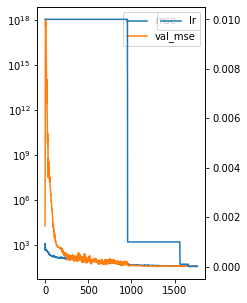

/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt/20220425_Miguel
Saved model!
Model: "ResNet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_translation_1 (Rando  multiple                 0         
 mTranslation)                                                   
                                                                 
 sequential_1 (Sequential)   (None, 1, 1, 512)         21303936  
                                                                 
 global_average_pooling2d_1   multiple                 0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             multiple                  527360    
                                                                 
 dropout_2 (Dropout)         multiple                  0         
             

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
def train_model(dataset, val_dataset=None):
    if not val_dataset:
        val_dataset = dataset['val']
#     for k in dataset:
#         imgs = dataset[k][0][0]
#         norm_imgs = imgs / imgs.max(axis=(1, 2))[:, np.newaxis, np.newaxis]
#         dataset[k][0][0] = norm_imgs

    model = load_regression_model()

    callbacks = [
        ReduceLROnPlateau(
        monitor='loss', factor=0.1, patience=50, verbose=True,
        mode='min', min_delta=1, cooldown=50, min_lr=1e-10,),
#         ReduceLROnPlateau(
#         monitor='val_mean_absolute_error', factor=0.1, patience=50, verbose=True,
#         mode='min', min_delta=1, cooldown=50, min_lr=1e-10,),
        EarlyStopping(monitor='val_mean_absolute_error', patience=500, verbose=True, min_delta=1, restore_best_weights=True),
#         TqdmCallback(verbose=1)
    ]

#     print(dataset['train'][0][0].shape)
#     print(dataset['train'][0][1].shape)
#     print(dataset['train'][1].shape)

    history = model.fit(*dataset['train'], epochs=5000, batch_size=2**15, validation_data=(*val_dataset,), callbacks=callbacks, verbose=True)

    fig, ax1 = plt.subplots()
    ax1.plot(history.history['mean_absolute_error'], label='mse')
    ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
    ax1.set_yscale('log')
    ax1.legend(loc=1)
    ax2 = ax1.twinx()
    ax2.plot(history.history['lr'], label='lr')
    ax2.legend(loc=0)

    plt.show()
    return model

TRAIN_NEW_MODEL = True

if TRAIN_NEW_MODEL:
    model = train_model(train_dataset.data)
    save_model(model)
else:
    model = load_model(load_regression_model())

tmp_x = train_dataset.data['train'][0][0][0:2], train_dataset.data['train'][0][1][0:2]
model(tmp_x)
print(model.summary())

In [ ]:
save_model(model)

In [21]:
%load_ext autoreload
%autoreload 2
from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import StormDataset, ExperimentalDataSet

dataset ='20220607_nanoruler_miguel'

cfg = dataset_configs[dataset]['storm_slide_1500']
ds = StormDataset(cfg, normalize_psf=True, lazy=True)
ds.csv_data = ds.csv_data[ds.csv_data['sigma [nm]'] > 20]
ds.prepare_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/20220607_nanoruler_miguel/B4/FOV6/storm_1500nm_1/storm_1500nm_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20220607_nanoruler_miguel/B4/FOV6/storm_1500nm_1/storm_1500nm_1_MMStack_Default.csv
127230 emitters before filtering


  0%|          | 173/120742 [00:00<01:10, 1721.79it/s]

120742 emitters after borders


100%|██████████| 120742/120742 [01:10<00:00, 1716.02it/s]


Clustering emitters...
Initial: N images 120742 - DF: (120742, 10)
Final: images 481 - DF: (481, 12)


(array([442.,   7.,   1.,   0.,   1.,  20., 207., 211.,  38.,   1.]),
 array([  0.79043667,  18.55447817,  36.31851967,  54.08256117,
         71.84660267,  89.61064417, 107.37468567, 125.13872717,
        142.90276867, 160.66681017, 178.43085167]),
 <BarContainer object of 10 artists>)

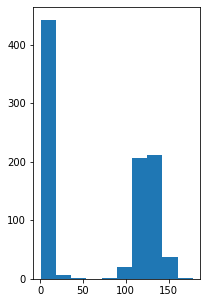

In [19]:
plt.hist(ds.csv_data['sigma [nm]'])

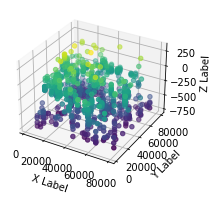

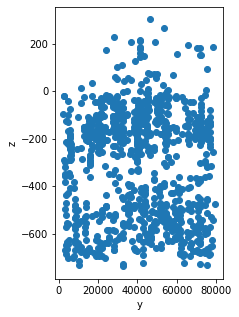

Mean error 194.40871551077936


In [18]:
from final_project.smlm_3d.data.visualise import scatter_3d, scatter_yz
from skspatial.objects.plane import Plane
coords = ds.predict_dataset(model).squeeze()

scatter_3d(coords)
scatter_yz(coords)
p = Plane.best_fit(coords)
residuals = np.array([p.distance_point(coords[i]) for i in range(coords.shape[0])])
print(f'Mean error', residuals.mean())

In [ ]:
test_x, test_y = train_dataset.data['test']
pred_y = model.predict(test_x).squeeze()
error = np.sort(abs(test_y-pred_y))
print(f'Mean error {np.mean(error)}')
print(f'std error {np.std(error)}')

plt.scatter(test_y, pred_y)
plt.show()

In [ ]:
test_x, test_y = train_dataset.data['test']
pred_y = model.predict(test_x).squeeze()
error = abs(test_y-pred_y)
print(f'Mean error {np.mean(error)}')
print(f'std error {np.std(error)}')

# Mean error 32.48721585546437
# std error 34.79553158370339


idx = np.argsort(pred_y)
test_imgs = test_x[0].squeeze()[idx]
plt.rcParams['figure.figsize'] = [30, 50]
plt.imshow(grid_psfs(test_imgs))
plt.show()

plt.rcParams['figure.figsize'] = [3, 5]
plt.scatter(test_y, pred_y)
plt.show()
error = abs(pred_y-test_y)
plt.boxplot(error)
plt.show()

In [ ]:
test_imgs_idx = np.random.choice(list(range(len(train_dataset.data['test'][0][0]))), 500)

test_imgs = train_dataset.data['test'][0][0][test_imgs_idx]
test_imgs_coords = train_dataset.data['test'][0][1][test_imgs_idx]
test_imgs_z_coords = train_dataset.data['test'][1][test_imgs_idx]

sort_idx = np.argsort(test_imgs_z_coords)
test_imgs = test_imgs[sort_idx]
test_imgs_coords = test_imgs_coords[sort_idx]
test_imgs_z_coords = test_imgs_z_coords[sort_idx]

pred_z_coords = model.predict((test_imgs, test_imgs_coords)).squeeze()

plt.scatter(test_imgs_z_coords, pred_z_coords, marker='.')
plt.show()


In [ ]:
from matplotlib import colors

norm = colors.Normalize(-1000, 1000)
mean_train_img = np.mean(train_dataset.data['train'][0][0].squeeze(), axis=(0,))

def explain_img_pixels(model, img, img_coords, mean_train_img):
    img = img[np.newaxis]
    img_coords = img_coords[np.newaxis]
    base_z_pred = model.predict((img, img_coords))
    
    shap_img = np.zeros(img.shape).squeeze()
    
    
    masked_imgs = np.tile(img, (img.shape[1]*img.shape[2], 1, 1, 1))
    img_coords = np.tile(img_coords, (img.shape[1]*img.shape[2], 1))
    
    coords = [(x, y) for x in range(img.shape[1]) for y in range(img.shape[2])]
    for i in range(len(masked_imgs)):
        x, y = coords[i]
        masked_imgs[i][y][x] = mean_train_img[y][x]
        
    z_preds =  model.predict((masked_imgs, img_coords))
    z_preds -= base_z_pred
    shap_img = np.reshape(z_preds, (img.shape[1], img.shape[2])).T
    
    f, axarr = plt.subplots(1, 2)
    
    axarr[0].imshow(shap_img, cmap='RdBu')
    axarr[0].set_title(f'{round(float(shap_img.min()), 3)}, {round(float(shap_img.max()), 3)}')
    axarr[1].imshow(img.squeeze())
    axarr[1].set_title(f'{round(float(img.min()), 3)}, {round(float(img.max()), 3)}')

#     plt.title(str(base_z_pred.squeeze()))
    plt.show()
            
            
            
            

for i in range(20):
    explain_img_pixels(model, test_imgs[i], test_imgs_coords[i], mean_train_img)

# imgs = storm_ds.data[0].squeeze()[35]
# plt.imshow(imgs)
# plt.show()

# def explain_prediction(img, model):
#     pass
    

In [ ]:
# %load_ext autoreload
# %autoreload 2

# from final_project.smlm_3d.config.datasets import dataset_configs
# from final_project.smlm_3d.data.datasets import GenericDataSet, ExperimentalDataSet, StormDataset, MultiImageStormDataset


# cfg = dataset_configs['20220425_Miguel']['storm_slide']
# storm_ds = MultiImageStormDataset(cfg, lazy=True)
# print(list(storm_ds.csv_data))
# storm_ds.csv_data = storm_ds.csv_data[storm_ds.csv_data['intensity [photon]'] > 10000]
# storm_ds.csv_data = storm_ds.csv_data[storm_ds.csv_data['uncertainty_xy [nm]'] < 50]
# storm_ds.csv_data = storm_ds.csv_data.sample(n=min([10000, storm_ds.csv_data.shape[0]]))
# storm_ds.prepare_data()

In [ ]:
# %matplotlib inline
# import pandas as pd
# import matplotlib.pyplot as plt
# from final_project.smlm_3d.data.visualise import grid_psfs

# mins = storm_ds.data[0].min(axis=(1,2,3))
# maxs = storm_ds.data[0].max(axis=(1,2,3))
# avgs = storm_ds.data[0].mean(axis=(1,2,3))
# rhos = storm_ds.data[1][:, 0]
# thetas = storm_ds.data[1][:, 1]

# summary_df = pd.DataFrame.from_dict({
#     'min': mins,
#     'max': maxs,
#     'avg': avgs,
#     'rho': rhos,
#     'theta': thetas
# })
# plt.rcParams['figure.figsize'] = [3, 3]
# summary_df.boxplot(list(summary_df))
# plt.show()
    
# plt.rcParams['figure.figsize'] = [50, 50]
# plt.imshow(grid_psfs(storm_ds.data[0][0:50].squeeze()))
# plt.show()


In [ ]:
# %load_ext autoreload
# %autoreload 2
# import matplotlib
# import matplotlib.pyplot as plt
# from final_project.smlm_3d.data.visualise import scatter_3d


# from final_project.smlm_3d.config.datasets import dataset_configs
# from final_project.smlm_3d.data.datasets import GenericDataSet, ExperimentalDataSet, StormDataset, MultiImageStormDataset

# font = {'size'   : 14}
# plt.rcParams['figure.figsize'] = [10, 10]
# matplotlib.rc('font', **font)
# pred_coords = storm_ds.predict_dataset(model)

# print(pred_coords.shape)
# not_nan_idx = ~np.isnan(pred_coords).any(axis=1)
# pred_coords = pred_coords[not_nan_idx]
# print(pred_coords.shape)

# z_shift = pred_coords[:, 2] - storm_ds.xyz_coords[not_nan_idx][:, 2]


In [ ]:
# %matplotlib inline
# plt.rcParams['figure.figsize'] = [50, 50]
# pred_sorted_idx = np.argsort(z_shift)
# pred_sorted_idx = pred_sorted_idx[np.random.choice(len(pred_sorted_idx), size=100, replace=False)]
# psfs = storm_ds.data[0][pred_sorted_idx]
# plt.imshow(grid_psfs(psfs.squeeze()))
# plt.show()


In [ ]:
# %matplotlib inline
# mean_train_img = np.mean(storm_ds.data[0].squeeze(), axis=0)

# for i in range(10):
#     test_img = storm_ds.data[0][i]
#     test_coords = storm_ds.data[1][i]
#     res = model.call_with_dropout((storm_ds.data[0][i:i+1], storm_ds.data[1][i:i+1]), True)
#     print(f'Mean: {round(np.mean(res), 3)} Std {round(np.std(res), 3)}')
#     explain_img_pixels(model, test_img, test_coords, mean_train_img)


In [ ]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib notebook
# import pandas as pd

# import seaborn as sns
# from final_project.smlm_3d.data.visualise import create_rotating_3d_plot

# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 50  
# plt.ioff()

# plt.rcParams['figure.figsize'] = [10, 10]

# anim = create_rotating_3d_plot(pd.DataFrame(pred_coords, columns=['x', 'y', 'z']))


# scatter_3d(pred_coords)

# sns.scatterplot(pred_coords[:, 0], pred_coords[:, 1], hue=pred_coords[:, 2])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()


# sns.scatterplot(pred_coords[:, 1], pred_coords[:, 2], hue=pred_coords[:, 0])
# plt.xlabel('y')
# plt.ylabel('z')
# plt.show()


# sns.scatterplot(pred_coords[:, 0], pred_coords[:, 2], hue=z_shift)
# plt.xlabel('x')
# plt.ylabel('z')
# plt.show()

In [ ]:
# %load_ext autoreload
# %autoreload 2

# from final_project.smlm_3d.debug_tools.est_calibration_stack_error import fit_plane
# %matplotlib inline
# residuals, points, subset_idx = fit_plane(pred_coords, subset=False)
# plt.boxplot(abs(residuals))
# plt.ylabel('Distance from plane (nm)')
# plt.title(f'Mean: {round(np.mean(abs(residuals)), 3)}')
# plt.show()

# plt.scatter(pred_coords[:, 0], residuals, alpha=0.1, s=1)
# plt.xlabel('x pos (nm)')
# plt.ylabel('distance from plane in z (nm)')
# plt.show()

# plt.scatter(pred_coords[:, 1], residuals, alpha=0.1, s=1)
# plt.xlabel('y pos (nm)')
# plt.ylabel('distance from plane in z (nm)')
# plt.show()

In [ ]:
# %load_ext autoreload
# %autoreload 2

# from final_project.smlm_3d.experiments.model_sphere import fit_sphere
# from final_project.smlm_3d.data.visualise import plot_w_dist

# plt.rcParams['figure.figsize'] = [5, 5]

# coords_df = pd.DataFrame(pred_coords, columns=['x', 'y', 'z'])

# radius = 1e6
# centre, residuals = fit_sphere(coords_df, radius, with_bounds=False)

# plot_w_dist(centre, coords_df.to_numpy(), radius, z_shift=z_shift)


# subset = np.where(abs(residuals) < np.percentile(abs(residuals), 95))

# coords_df = coords_df.iloc[subset]
# centre, residuals = fit_sphere(coords_df, radius, with_bounds=False)
# plot_w_dist(centre, coords_df.to_numpy(), radius, z_shift=z_shift[subset])


In [ ]:
# print(np.mean(abs(residuals)))
# plt.boxplot(abs(residuals))
# plt.show()


In [ ]:
# imgs = storm_ds.data[0].squeeze()


# pred_z_coords = pred_coords[:, 2]
# sds = np.std(imgs, axis=(1,2))
# idx = np.argsort(pred_z_coords)
# img = grid_psfs(imgs[idx][0:100])
# plt.rcParams['figure.figsize'] = [300, 300]
# plt.imshow(img)
# plt.show()



In [ ]:
%load_ext autoreload
%autoreload 2

from final_project.smlm_3d.data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere, grid_psfs, plot_w_dist
from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import ExperimentalDataSet
from final_project.smlm_3d.experiments.model_sphere import fit_sphere

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
ExperimentalDataSet.bound = BOUND
print(f'Dataset: {dataset}')
cfg = dataset_configs[dataset]['experimental']
exp_dataset = ExperimentalDataSet(cfg, transform_data=False, filter_localisations=False)
# psfs = grid_psfs(np.moveaxis(exp_dataset.data[0], 3, 1)).squeeze()

# plt.imshow(psfs)
# plt.show()


def eval_sphere_fit(coords, z_diff):
    radius = 5e5 + 50
    cols = ['x', 'y', 'z']
    orig_df = pd.DataFrame(coords, columns=cols)
    centre, res = fit_sphere(orig_df, radius, top_or_bottom = cfg['side_of_sphere'])
    
    plt.figure()
    ax = plt.gca()
    sns.scatterplot(coords[:, 0], coords[:, 2], hue=z_diff)
    circle = plt.Circle((centre[1], centre[2]), radius=radius, fill=False)
    ax.add_artist(circle)
    plt.xlabel('x')
    plt.ylabel('z')
    plt.show()
    plot_w_dist(centre, coords, radius, z_diff)
    worst_imgs = np.argsort(abs(res))[::-1]
#     for i in worst_imgs[0:10]:
#         print(i, z_diff[i], res[i])
#         plt.imshow(exp_dataset.data[0][i])
#         plt.show()
    
    res = abs(res)
#     res = res[res < np.percentile(res, 75)]
    plt.boxplot(res)
    plt.show()
    print(np.mean(res))
    print(np.std(res))
    return res
    
    

scatter_yz(exp_dataset.xyz_coords)
original_coords = exp_dataset.xyz_coords.copy()
# eval_sphere_fit(original_coords)

new_coords = exp_dataset.predict_dataset(model)
z_diff = (new_coords[:, 2] - original_coords[:, 2])
res = eval_sphere_fit(new_coords, z_diff)
print(z_diff[0:5])


# plt.figure()
# ax = plt.gca()
# plt.scatter(original_coords[:, 0], original_coords[:, 2])
# circle = plt.Circle((5e5, old_sphere_centre[2]), radius=5e5, fill=False)
# ax.add_artist(circle)
# plt.xlabel('x')
# plt.ylabel('z')
# plt.show()


# df.to_csv('/home/miguel/Projects/uni/phd/smlm_z/tmp.csv', index=False)


In [ ]:
df = gather_stats(exp_dataset.data, 'exp', 'experimental')
train_df = gather_stats(train_dataset.data['train'], 'training')
val_df = gather_stats(train_dataset.data['val'], 'val')

concat_df = pd.concat((df, train_df, val_df))
for col in list(concat_df):
    if col != 'name':
        concat_df.boxplot(by='name', column=col)
        plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [30, 50]

def order_all_psfs(c, psfs):
    sort_idx = np.argsort(c)
    psfs_ordered = psfs[sort_idx]
    plt.imshow(grid_psfs(psfs_ordered))
    plt.show()
    plt.plot(c[sort_idx])
    plt.show()

# exp_dataset.prepare_debug()
# n_psfs = exp_dataset.csv_data.shape[0]
# psfs = []
# for i in range(n_psfs):
#     psfs.append(exp_dataset.debug_emitter(0, z_range=1000, normalize=False)[0].squeeze())
print(exp_dataset.data[0].squeeze().shape)
order_all_psfs(z_diff, exp_dataset.data[0].squeeze())
plt.rcParams['figure.figsize'] = [10, 5]


In [ ]:
# from final_project.smlm_3d.workflow_v2 import eval_model, shift_correction as original_shift_correction

# cfg = dataset_configs['matched_index_sphere']['sphere_ground_truth_647nm']
# ds = TrainingDataSet(cfg, transform_data=False, z_range=1000, split_data=False, add_noise=False, filter_emitters_proximity=False, lazy=True)
# ds.prepare_debug()



In [ ]:
# %load_ext autoreload
# %autoreload 2
# plt.rcParams['figure.figsize'] = [20, 5]
# errors = []
# from sklearn.metrics import mean_absolute_error

# for i in range(0, ds.csv_data.shape[0]):
#     psfs, polar_coords, coords, z, row_data = ds.debug_emitter(i, z_range=1000, normalize=True)
#     psfs = psfs[:, :, :, np.newaxis]
#     polar_coords = np.repeat(polar_coords, psfs.shape[0], axis=0)
#     pred_z = model.predict((psfs, polar_coords))
#     error = mean_absolute_error(z, pred_z)
#     errors.append(error)

# errors_idx = np.argsort(errors)[::-1]

# for i in errors_idx[0:20]:
#     psfs, polar_coords, coords, z, row_data = ds.debug_emitter(i, z_range=1000, normalize=True)
#     psfs = psfs[:, :, :, np.newaxis]
#     polar_coords = np.repeat(polar_coords, psfs.shape[0], axis=0)
#     pred_z = model.predict((psfs, polar_coords))
#     plt.plot(z, pred_z, label='sphere')
    
    
#     psfs2, polar_coords, _, z, _ = train_dataset.debug_emitter(np.random.randint(0, train_dataset.csv_data.shape[0]), z_range=1000, normalize=True)
#     psfs2 = psfs2[:, :, :, np.newaxis]
#     polar_coords = np.repeat(polar_coords, psfs.shape[0], axis=0)
#     pred_z = model.predict((psfs2, polar_coords))
#     plt.plot(z, pred_z, label='training')
#     plt.xlabel('True z (nm)')
#     plt.ylabel('Predicted z (nm)')
#     plt.legend()
#     plt.show()

#     show_psf_axial(psfs.squeeze(), '', 2)
#     show_psf_axial(psfs2.squeeze(), '', 2)



In [ ]:
# plt.scatter(test_y, pred, label=str(i), alpha=0.5, marker='x')
# plt.show()

# ae = test_y.squeeze()-pred.squeeze()

# plt.boxplot(ae)
# plt.show()
# print(np.mean(ae))

# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]

# ae = list(map(np.mean, chunks(ae, 199)))

In [ ]:
# import seaborn as sns
# sub_df = exp_dataset.csv_data
# sub_df['mean_error [nm]'] = ae

# sub_df['id'] = list(range(sub_df.shape[0]))
# # cols = ['chi2']
# # for c in cols:
# #     sub_df.plot.scatter(c, 'mean_error [nm]')
# #     plt.show()

# worst_images = sub_df.sort_values(by='mean_error [nm]', ascending=False)
# worst_idx = list(worst_images['id'][0:5])
# best_idx = list(worst_images['id'][-5:-1])

# for idx in worst_idx:
#     start = idx*(199)
#     end = (idx+1)*199
#     imstack_idx = slice(start, end, 25)
#     imstack = exp_dataset.data['all'][0][0][imstack_idx]
#     for img in imstack:
#         plt.imshow(img)
#         plt.show()
#     print('break')